# Graph Neural Networks to Predict Missing Virus-Host Links

In [50]:
import os
import pandas as pd
import torch

from torch_geometric import seed_everything
seed_everything(12345)

## Set up dfencoder

In [51]:
from dfencoder import AutoEncoder
import numpy as np

In [52]:
#load and look at the data
virus_df = pd.read_csv('../../data/viruses/virus_traits_bool.csv')

#this dataset contains nulls and ' ?'. Let's make these all nulls.
virus_df = virus_df.map(lambda x: np.nan if x==' ?' else x)

#drop columns we do not want to encode
virus_df.drop(columns=["Unnamed: 0","Species","NCBI Taxon ID"], axis=1, inplace=True)

virus_df.dtypes
virus_df.head()

,Order,Family,Genus,envelope,circular,double_stranded,rna,segmented,positive_sense,negative_sense,...,gc,genes,budding,lysis,release_other,cytoplasm,CE_clathrin,CE_receptor,CE_glycoproteins,CE_other
0,Chitovirales,Poxviridae,Avipoxvirus,True,False,True,False,True,False,False,...,31.0,260.0,False,True,False,True,False,False,True,False
1,Chitovirales,Poxviridae,Avipoxvirus,True,False,True,False,True,False,False,...,29.5,271.0,False,True,False,True,False,False,True,False
2,Blubervirales,Hepadnaviridae,Orthohepadnavirus,True,True,True,False,True,False,False,...,48.5,4.0,True,False,False,False,False,False,True,False
3,Rowavirales,Adenoviridae,Mastadenovirus,False,False,True,False,False,False,False,...,NaN,NaN,False,True,False,False,False,False,True,False
4,Reovirales,NaN,NaN,False,False,True,True,True,False,False,...,NaN,NaN,True,True,True,True,False,True,False,False


In [53]:
#divide data into training and testing
virus_train = virus_df.sample(frac=.8, random_state=42)
virus_test = virus_df.loc[~virus_df.index.isin(virus_train.index)]

X_train_v = virus_train
X_val_v = virus_test

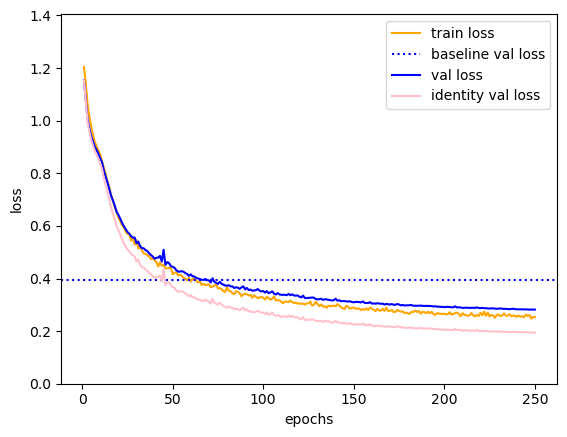

In [54]:
#build model
virus_model = AutoEncoder(
    encoder_layers = [21, 128, 21], #model architecture
    decoder_layers = [], #decoder optional - you can create bottlenecks if you like
    activation='relu',
    swap_p=0.2, #noise parameter
    lr = 0.01,
    lr_decay=0.99,
    batch_size=32,
    logger='ipynb', #special logging for jupyter notebooks
    verbose=False,
    optimizer='sgd',
    scaler='gauss_rank', #gauss rank scaling forces your numeric features into standard normal distributions
    min_cats=0 #Define cutoff for minority categories, default 10
)
virus_model.fit(X_train_v, epochs=250, val=X_val_v)

In [55]:
test_df_v = virus_df.loc[:4]
test_df_v

,Order,Family,Genus,envelope,circular,double_stranded,rna,segmented,positive_sense,negative_sense,...,gc,genes,budding,lysis,release_other,cytoplasm,CE_clathrin,CE_receptor,CE_glycoproteins,CE_other
0,Chitovirales,Poxviridae,Avipoxvirus,True,False,True,False,True,False,False,...,31.0,260.0,False,True,False,True,False,False,True,False
1,Chitovirales,Poxviridae,Avipoxvirus,True,False,True,False,True,False,False,...,29.5,271.0,False,True,False,True,False,False,True,False
2,Blubervirales,Hepadnaviridae,Orthohepadnavirus,True,True,True,False,True,False,False,...,48.5,4.0,True,False,False,False,False,False,True,False
3,Rowavirales,Adenoviridae,Mastadenovirus,False,False,True,False,False,False,False,...,NaN,NaN,False,True,False,False,False,False,True,False
4,Reovirales,NaN,NaN,False,False,True,True,True,False,False,...,NaN,NaN,True,True,True,True,False,True,False,False


In [56]:
rep = virus_model.get_representation(test_df_v)
rep

tensor([[ 0.0000,  0.0000,  7.6859,  1.5911,  2.1030,  7.6466, 17.4585,  0.0000,
         18.4203,  2.1587,  4.7256,  0.5812,  8.8344,  0.0000,  5.3948,  0.0000,
         16.7301,  2.9592, 11.3779,  0.0000,  2.2662],
        [ 0.0000,  0.0000,  8.1038,  2.0279,  2.1958,  8.1977, 17.6475,  0.0000,
         18.3051,  2.1175,  4.7594,  0.2677,  8.8635,  0.0385,  5.9170,  0.0000,
         16.9261,  2.9993, 11.0814,  0.0000,  2.0224],
        [ 0.0000,  0.0000,  1.6039,  8.5153,  3.3843,  1.0315,  3.9425,  0.0000,
          2.7343,  0.4728,  1.6774,  3.7281,  1.9301,  2.9280,  2.0758,  0.0000,
          0.0000,  2.5504,  0.7684,  0.0000,  3.4219],
        [ 0.0000,  0.0000,  5.7410,  0.8644,  2.4121,  7.0487, 17.5095,  0.0000,
          7.1074,  3.5020, 12.2967, 12.1572,  3.3670,  0.0000, 11.9615,  0.0000,
         12.9325, 12.6868,  5.6557,  0.0000,  9.3430],
        [ 0.0000,  0.0000, 10.1672, 13.9936,  6.0187, 14.2033, 19.0305,  0.0000,
         10.6229,  0.7727,  4.0914,  6.2047,  9.143

Avian dfencoder model

In [59]:
#load and look at the data
bird_df = pd.read_csv('../../data/hosts/birds/birds_traits.csv')

#this dataset contains nulls and ' ?'. Let's make these all nulls.
bird_df = bird_df.map(lambda x: np.nan if x==' ?' else x)
# df.drop(columns=["Unnamed: 0", "scientific name", "alternative name", "taxid"], axis=1, inplace=True)
bird_df.drop(columns=["Unnamed: 0", "scientific name","alternative name","taxid"], axis=1, inplace=True)

bird_df.dtypes
bird_df.head()

,order,family,mass,trophic level,trophic niche,primary lifestyle,range size,habitat,habitat density,migration,evolutionary distinctiveness
0,Psittaciformes,Psittacidae,120.00,Herbivore,Omnivore,Insessorial,2854802.75,Human Modified,2,1,111.124595
1,Anseriformes,Anatidae,1118.00,Herbivore,Herbivore aquatic,Aquatic,6127779.64,Wetland,3,2,111.124595
2,Psittaciformes,Psittacidae,274.59,Herbivore,Omnivore,Insessorial,1483974.66,Forest,1,1,111.124595
3,Passeriformes,Icteridae,160.47,Omnivore,Omnivore,Terrestrial,5121813.66,Human Modified,3,1,111.124595
4,Accipitriformes,Accipitridae,759.10,Carnivore,Vertivore,Insessorial,16600070.45,Grassland,3,2,111.124595


In [65]:
bird_train = bird_df.sample(frac=.8, random_state=42)
bird_test = bird_df.loc[~bird_df.index.isin(bird_train.index)]

X_train_b = bird_train
X_val_b = bird_test


 46%|█████████████████████████████████████████████████▉                                                           | 11/24 [00:13<00:00, 87.28it/s]

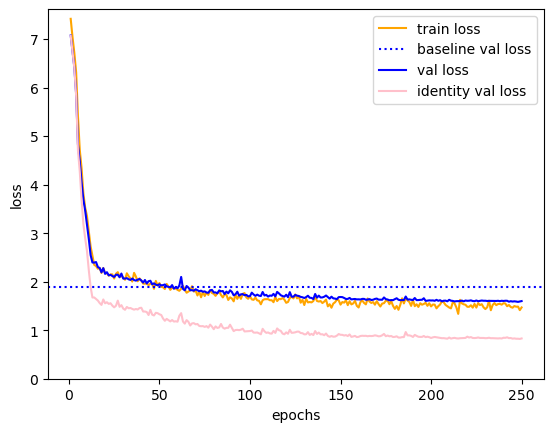

In [68]:
bird_model = AutoEncoder(
    encoder_layers = [11, 64, 11], #model architecture
    decoder_layers = [], #decoder optional - you can create bottlenecks if you like
    activation='relu',
    swap_p=0.2, #noise parameter
    lr = 0.008,
    lr_decay=0.99,
    batch_size=32,
    logger='ipynb', #special logging for jupyter notebooks
    verbose=False,
    optimizer='sgd',
    scaler='gauss_rank', #gauss rank scaling forces your numeric features into standard normal distributions
    min_cats=0 #Define cutoff for minority categories, default 10
)
bird_model.fit(X_train_b, epochs=250, val=X_val_b)

In [69]:
test_m_df = bird_df.loc[:4]
test_m_df

,order,family,mass,trophic level,trophic niche,primary lifestyle,range size,habitat,habitat density,migration,evolutionary distinctiveness
0,Psittaciformes,Psittacidae,120.00,Herbivore,Omnivore,Insessorial,2854802.75,Human Modified,2,1,111.124595
1,Anseriformes,Anatidae,1118.00,Herbivore,Herbivore aquatic,Aquatic,6127779.64,Wetland,3,2,111.124595
2,Psittaciformes,Psittacidae,274.59,Herbivore,Omnivore,Insessorial,1483974.66,Forest,1,1,111.124595
3,Passeriformes,Icteridae,160.47,Omnivore,Omnivore,Terrestrial,5121813.66,Human Modified,3,1,111.124595
4,Accipitriformes,Accipitridae,759.10,Carnivore,Vertivore,Insessorial,16600070.45,Grassland,3,2,111.124595


In [70]:
rep = bird_model.df_predict(test_m_df)
rep

,order,family,mass,trophic level,trophic niche,primary lifestyle,range size,habitat,habitat density,migration,evolutionary distinctiveness
0,Psittaciformes,Psittacidae,135.997482,Herbivore,Omnivore,Insessorial,5.798175e+05,Forest,1.0,1.0,111.124596
1,Anseriformes,Anatidae,1797.308960,Herbivore,Herbivore aquatic,Aquatic,6.831453e+06,Wetland,3.0,2.0,111.124596
2,Psittaciformes,Psittacidae,167.920639,Herbivore,Omnivore,Insessorial,3.320321e+05,Forest,1.0,1.0,111.124596
3,Passeriformes,Corvidae,90.210777,Omnivore,Omnivore,Terrestrial,5.826246e+06,Shrubland,3.0,1.0,111.124596
4,Accipitriformes,Accipitridae,822.593872,Carnivore,Vertivore,Aerial,1.945953e+07,Woodland,3.0,3.0,111.124596


## Bird Data from Divide & Conquer

In [71]:
host_features_path = os.path.join('..', '..', 'data', 'hosts', 'birds', 'birds_traits.csv')
viral_features_path = os.path.join('..', '..', 'data', 'viruses', 'virus_traits_bool.csv')
interactions_path = os.path.join('..', '..', 'data', 'interactions', 'NCBI', 'filtered_virus_host_interactions.csv')

host_feats = pd.read_csv(host_features_path)
viral_feats = pd.read_csv(viral_features_path)
interactions = pd.read_csv(interactions_path)

This implementation is informed by the following PyG [tutorial](https://medium.com/@pytorch_geometric/link-prediction-on-heterogeneous-graphs-with-pyg-6d5c29677c70). The pathogen and host ID values uniquely identify the entities in our study, but they're also massive numbers. For data compactness, we will create a mapping from those to consecutive values in the range [0, num_entries].

In [72]:
unique_host_ids = host_feats['taxid'].unique()
host_id_mapping = pd.DataFrame(data={
    'hostID': unique_host_ids,
    'mappedID': pd.RangeIndex(len(unique_host_ids))
})
print("Head of the host id mapping DF:\n", host_id_mapping.head())

unique_virus_ids = viral_feats['NCBI Taxon ID'].unique()
virus_id_mapping = pd.DataFrame(data={
    'virusID': unique_virus_ids,
    'mappedID': pd.RangeIndex(len(unique_virus_ids))
})
print("\nHead of the virus id mapping DF:\n", virus_id_mapping.head())

Head of the host id mapping DF:
    hostID  mappedID
0  176066         0
1   30387         1
2  241588         2
3   64278         3
4  224669         4

Head of the virus id mapping DF:
    virusID  mappedID
0    10261         0
1    10264         1
2    10407         2
3    10535         3
4    10891         4


Now for interactions, we will create a torch matrix of shape ```(2, num_interactions)```. To do this, we will first use merges to get the corresponding mappedIDs.

In [73]:
interactions_host_ids = pd.merge(interactions['hostID'], host_id_mapping, left_on='hostID', right_on='hostID', how='left')
interactions_host_ids = torch.from_numpy(interactions_host_ids['mappedID'].values)

interactions_virus_ids = pd.merge(interactions['pathogenID'], virus_id_mapping, left_on='pathogenID', right_on='virusID', how='left')
interactions_virus_ids = torch.from_numpy(interactions_virus_ids['mappedID'].values)

edge_index_virus_to_host = torch.stack([interactions_virus_ids, interactions_host_ids], dim=0)
print(edge_index_virus_to_host.shape)

torch.Size([2, 3602])


PyG's tutorial for link prediction on heterogenous graphs recommends using their ```HeteroData``` object instead of a traditional Torch ```Dataset```.

In [74]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

device = 'cuda' if torch.cuda.is_available() else 'cpu'

data = HeteroData()

# For each class, store the node ids and the features. Features will be of shape (# nodes, # features)
data['virus'].node_id = torch.arange(len(unique_virus_ids))
# NOTE: this data doesn't have a one-hot encoding for the taxonomy. Could maybe capture this with get_dummies()
# problem is, there are like more than a 1000 of these.
temp_df_v =viral_feats.drop(columns=["Unnamed: 0","Species","NCBI Taxon ID"])
data['virus'].x = virus_model.get_representation(temp_df_v)

# TODO: will need to go back and make both one-hot and ordinal versions of this data for the horder and hfamily features
# That will add another 124 columns if one-hot encoded.  
# TODO: Will also need to come back and deal with the 'status' feature. It says whether the animal is wild or domesticated
# didn't realize that this wasn't already encoded better
data['host'].node_id = torch.arange(len(unique_host_ids))
temp_df_m =host_feats.drop(columns=["Unnamed: 0", "scientific name","alternative name","taxid"])

data['host'].x = bird_model.get_representation(temp_df_m)

# Add the edges
data['virus', 'infects', 'host'].edge_index = edge_index_virus_to_host

data = T.ToUndirected()(data)  # Add the reverse edges
print(data)

HeteroData(
  virus={
    node_id=[1795],
    x=[1795, 21],
  },
  host={
    node_id=[938],
    x=[945, 11],
  },
  (virus, infects, host)={ edge_index=[2, 3602] },
  (host, rev_infects, virus)={ edge_index=[2, 3602] }
)


In [75]:
split_transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=('virus', 'infects', 'host'),
    rev_edge_types=('host', 'rev_infects', 'virus')
)

train_data, val_data, test_data = split_transform(data)

print('Train Data:')
print(train_data)
print('\nVal Data:')
print(val_data)
print('\nTest Data:')
print(test_data)

Train Data:
HeteroData(
  virus={
    node_id=[1795],
    x=[1795, 21],
  },
  host={
    node_id=[938],
    x=[945, 11],
  },
  (virus, infects, host)={
    edge_index=[2, 2018],
    edge_label=[864],
    edge_label_index=[2, 864],
  },
  (host, rev_infects, virus)={ edge_index=[2, 2018] }
)

Val Data:
HeteroData(
  virus={
    node_id=[1795],
    x=[1795, 21],
  },
  host={
    node_id=[938],
    x=[945, 11],
  },
  (virus, infects, host)={
    edge_index=[2, 2882],
    edge_label=[1080],
    edge_label_index=[2, 1080],
  },
  (host, rev_infects, virus)={ edge_index=[2, 2882] }
)

Test Data:
HeteroData(
  virus={
    node_id=[1795],
    x=[1795, 21],
  },
  host={
    node_id=[938],
    x=[945, 11],
  },
  (virus, infects, host)={
    edge_index=[2, 3242],
    edge_label=[1080],
    edge_label_index=[2, 1080],
  },
  (host, rev_infects, virus)={ edge_index=[2, 3242] }
)


In [76]:
from torch_geometric.loader import LinkNeighborLoader

# NOTE: Not exactly sure what these two lines are doing - apparently define seed edges???
edge_label_index = train_data['virus', 'infects', 'host'].edge_label_index
edge_label = train_data['virus', 'infects', 'host'].edge_label

train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(('virus', 'infects', 'host'), edge_label_index),
    edge_label=edge_label,
    batch_size=128,
    shuffle=True
)

print("Example of a training mini-batch:")
print(next(iter(train_loader)))

# Also set up the loader for the validation set so that we can track the performance on that as we go
edge_label_index_val = val_data['virus', 'infects', 'host'].edge_label_index
edge_label_val = val_data['virus', 'infects', 'host'].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    edge_label_index=(('virus', 'infects', 'host'), edge_label_index_val),
    edge_label=edge_label_val,
    batch_size=128,
    shuffle=True
)
print("\nExample of a validation mini-batch:")
print(next(iter(val_loader)))

Example of a training mini-batch:
HeteroData(
  virus={
    node_id=[760],
    x=[760, 21],
    n_id=[760],
  },
  host={
    node_id=[938],
    x=[580, 11],
    n_id=[580],
  },
  (virus, infects, host)={
    edge_index=[2, 1285],
    edge_label=[384],
    edge_label_index=[2, 384],
    e_id=[1285],
    input_id=[128],
  },
  (host, rev_infects, virus)={
    edge_index=[2, 1074],
    e_id=[1074],
  }
)

Example of a validation mini-batch:
HeteroData(
  virus={
    node_id=[600],
    x=[600, 21],
    n_id=[600],
  },
  host={
    node_id=[938],
    x=[439, 11],
    n_id=[439],
  },
  (virus, infects, host)={
    edge_index=[2, 1213],
    edge_label=[128],
    edge_label_index=[2, 128],
    e_id=[1213],
    input_id=[128],
  },
  (host, rev_infects, virus)={
    edge_index=[2, 920],
    e_id=[920],
  }
)


/home/jqian/miniconda3/envs/avian_zoonosis/lib/python3.12/site-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


In [77]:
from models.standard import StandardModel

# For the birdian data, the number of features is like 30 and 60.
model = StandardModel(hidden_channels=64, metadata=data.metadata())
print(model)

StandardModel(
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (virus__infects__host): SAGEConv((-1, -1), 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv((-1, -1), 64, aggr=mean)
    )
    (conv2): ModuleDict(
      (virus__infects__host): SAGEConv(64, 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv(64, 64, aggr=mean)
    )
    (conv3): ModuleDict(
      (virus__infects__host): SAGEConv(64, 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv(64, 64, aggr=mean)
    )
    (conv4): ModuleDict(
      (virus__infects__host): SAGEConv(64, 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv(64, 64, aggr=mean)
    )
    (conv5): ModuleDict(
      (virus__infects__host): SAGEConv(64, 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv(64, 64, aggr=mean)
    )
    (conv6): ModuleDict(
      (virus__infects__host): SAGEConv(64, 64, aggr=mean)
      (host__rev_infects__virus): SAGEConv(64, 64, aggr=mean)
    )
    (conv7): ModuleDict(
      (virus__infect

In [78]:
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

print('Selected device: ', device)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_loss_hist = []
val_loss_hist = []
for epoch in range(10):
    epoch_loss = epoch_size = 0

    model.train()
    for sampled_data in tqdm(train_loader):
        optimizer.zero_grad()

        sampled_data = sampled_data.to(device)
        pred = model(sampled_data)
        
        labels = sampled_data['virus', 'infects', 'host'].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, labels)
        
        loss.backward()
        optimizer.step()

        epoch_loss += float(loss) * pred.numel()  # Default reduction is mean so multiplying by num elements recovers sum
        epoch_size += pred.numel()

    if epoch % 1 == 0:  # This is to control how often we validate. For now do every epoch since num epochs is low
        # NOTE: for now I'm just using AUROC since it's standard, but we should be using AUCPR instead 
        model.eval()
        val_preds = []
        val_labels = []
        for sampled_data in tqdm(val_loader):
            with torch.no_grad():
                sampled_data = sampled_data.to(device)
                val_preds.append(model(sampled_data))
                val_labels.append(sampled_data['virus', 'infects', 'host'].edge_label)
            
        val_preds = torch.cat(val_preds, dim=0)
        val_labels = torch.cat(val_labels, dim=0)
        val_loss = F.binary_cross_entropy_with_logits(val_preds, val_labels).cpu().item()
        val_loss_hist.append(val_loss)
        auroc = roc_auc_score(val_labels.cpu().numpy(), val_preds.cpu().numpy())
    
    print(f'Epoch: {epoch}, Train Loss: {epoch_loss / epoch_size:.4f}, Validation Loss: {val_loss}, AUROC: {auroc}')
    train_loss_hist.append(epoch_loss / epoch_size)

Selected device:  cpu


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 173.53it/s]


Epoch: 0, Train Loss: 0.6411, Validation Loss: 0.534191906452179, AUROC: 0.7990335648148149


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 203.48it/s]


Epoch: 1, Train Loss: 0.5174, Validation Loss: 0.4559003412723541, AUROC: 0.8473476080246913


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 207.66it/s]


Epoch: 2, Train Loss: 0.4565, Validation Loss: 0.41566574573516846, AUROC: 0.8774556327160492


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 197.54it/s]


Epoch: 3, Train Loss: 0.4014, Validation Loss: 0.36802351474761963, AUROC: 0.904735725308642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 148.79it/s]


Epoch: 4, Train Loss: 0.3828, Validation Loss: 0.3583526611328125, AUROC: 0.9124209104938272


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 244.99it/s]


Epoch: 5, Train Loss: 0.3575, Validation Loss: 0.3353763222694397, AUROC: 0.9235204475308642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 222.22it/s]


Epoch: 6, Train Loss: 0.3372, Validation Loss: 0.30392152070999146, AUROC: 0.937494212962963


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 221.55it/s]


Epoch: 7, Train Loss: 0.3241, Validation Loss: 0.3103441894054413, AUROC: 0.9376639660493827


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 189.43it/s]


Epoch: 8, Train Loss: 0.3107, Validation Loss: 0.297296941280365, AUROC: 0.9383699845679012


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 229.97it/s]

Epoch: 9, Train Loss: 0.3090, Validation Loss: 0.31347593665122986, AUROC: 0.931784336419753


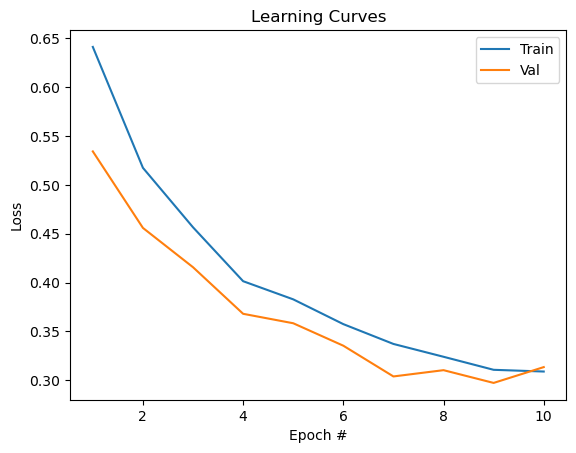

In [79]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.plot(np.arange(1, 11), train_loss_hist, label='Train')
plt.plot(np.arange(1, 11), val_loss_hist, label='Val')
plt.title('Learning Curves')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()
plt.show()

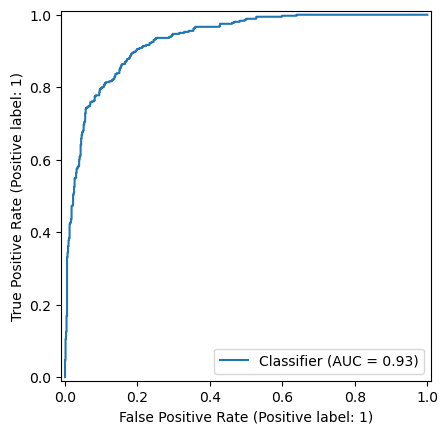

In [80]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(val_labels.cpu().numpy(), val_preds.cpu().numpy())
plt.show()